
========== Đang huấn luyện Transformer cho nồng độ: 250500 ==========


c:\Users\d5a2m\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.0605
Epoch 10/50, Loss: 0.0285
Epoch 20/50, Loss: 0.0278
Epoch 30/50, Loss: 0.0269
Epoch 40/50, Loss: 0.0258
Epoch 50/50, Loss: 0.0253
R^2: 0.9108
MAE: 0.1917
MAPE: 134.86%
RMSE: 0.2514


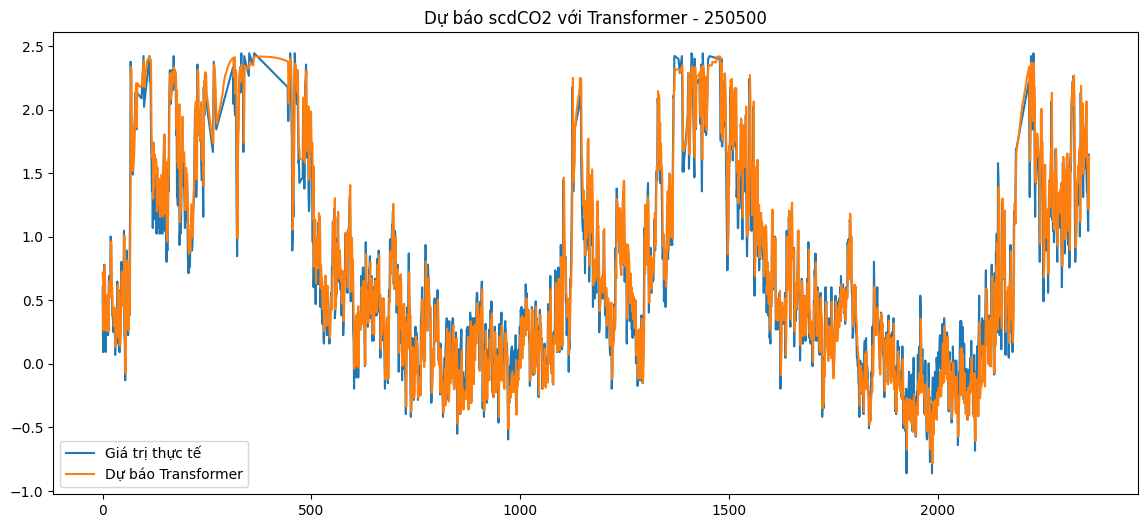


========== Đang huấn luyện Transformer cho nồng độ: 500500 ==========


c:\Users\d5a2m\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.1024
Epoch 10/50, Loss: 0.0661
Epoch 20/50, Loss: 0.0627
Epoch 30/50, Loss: 0.0624
Epoch 40/50, Loss: 0.0607
Epoch 50/50, Loss: 0.0612
R^2: 0.9355
MAE: 0.2080
MAPE: 766.87%
RMSE: 0.2774


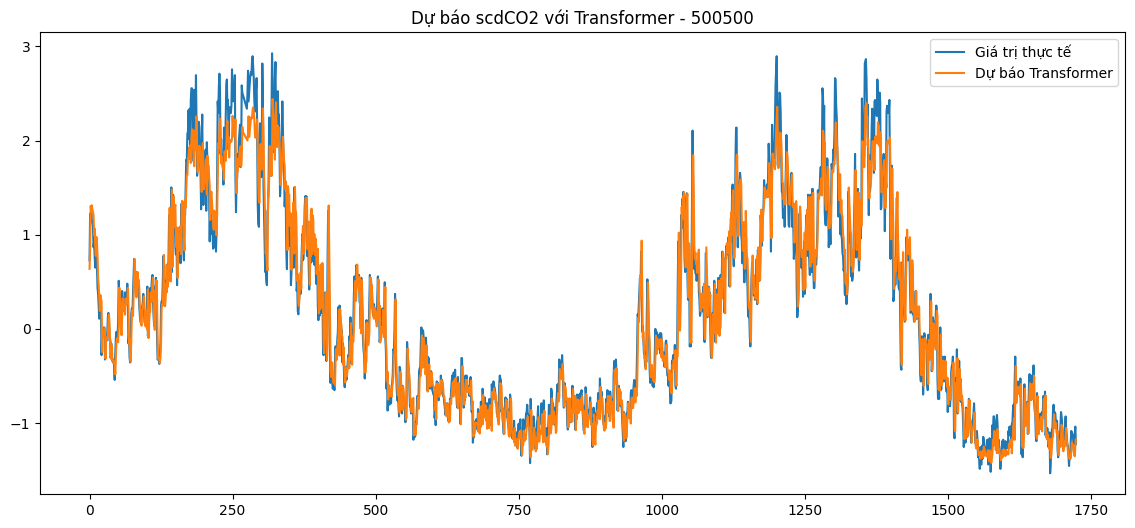


========== Đang huấn luyện Transformer cho nồng độ: 750500 ==========


c:\Users\d5a2m\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.0928
Epoch 10/50, Loss: 0.0719
Epoch 20/50, Loss: 0.0708
Epoch 30/50, Loss: 0.0702
Epoch 40/50, Loss: 0.0694
Epoch 50/50, Loss: 0.0690
R^2: 0.9279
MAE: 0.1770
MAPE: 118.98%
RMSE: 0.2397


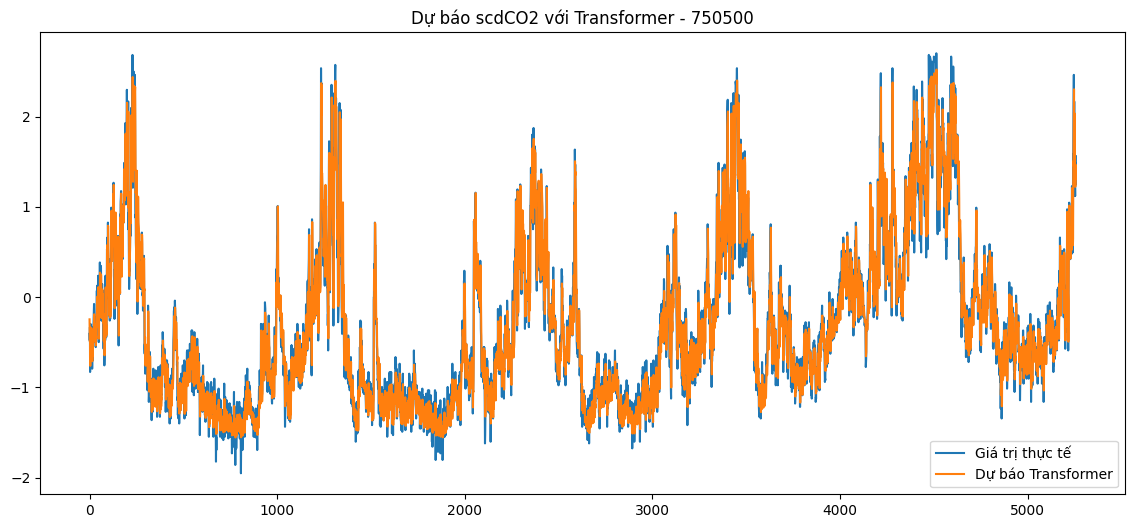


Bảng tổng hợp chỉ số các nồng độ:
  nồng độ        R2       MAE        MAPE      RMSE
0  250500  0.910755  0.191707  134.864138  0.251406
1  500500  0.935513  0.208013  766.867337  0.277352
2  750500  0.927896  0.177030  118.975632  0.239736


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Thiết lập thiết bị (GPU nếu có)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Đường dẫn dữ liệu
base_dir = r'E:\Khóa luận\Data\Phase 2'
concentration_files = {
    '250500': 'preprocessed_250500.csv',
    '500500': 'preprocessed_500500.csv',
    '750500': 'preprocessed_750500.csv'
}

target_col = 'scdCO2'
window_size = 24
d_model = 32  # Số chiều embedding

class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.model_type = 'Transformer'
        self.embedding = nn.Linear(feature_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        # src shape: (batch, seq_len, feature_size)
        src = self.embedding(src)  # (batch, seq_len, d_model)
        src = src.permute(1, 0, 2)  # (seq_len, batch, d_model)
        output = self.transformer_encoder(src)
        output = output[-1, :, :]  # Lấy output cuối cùng
        output = self.decoder(output)
        return output.squeeze()

metrics = []

for label, fname in concentration_files.items():
    print(f'\n========== Đang huấn luyện Transformer cho nồng độ: {label} ==========')
    file_path = os.path.join(base_dir, fname)
    df = pd.read_csv(file_path)
    df['Date time'] = pd.to_datetime(df['Date time'])
    df = df.sort_values('Date time').reset_index(drop=True)

    # Chuẩn bị dữ liệu window
    values = df[target_col].values
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:i+window_size])
        y.append(values[i+window_size])
    X = np.array(X)
    y = np.array(y)

    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Đưa về tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Khởi tạo model
    model = TimeSeriesTransformer(feature_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Huấn luyện
    n_epochs = 50
    batch_size = 64
    for epoch in range(n_epochs):
        model.train()
        perm = torch.randperm(X_train_tensor.size(0))
        sum_loss = 0
        for i in range(0, X_train_tensor.size(0), batch_size):
            idx = perm[i:i+batch_size]
            batch_X = X_train_tensor[idx]
            batch_y = y_train_tensor[idx]
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * batch_X.size(0)
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Loss: {sum_loss/X_train_tensor.size(0):.4f}')

    # Dự báo
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).cpu().numpy()

    # Tính các chỉ số
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'R^2: {r2:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSE: {rmse:.4f}')

    metrics.append({
        'nồng độ': label,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    })

    # Vẽ biểu đồ so sánh dự báo và thực tế
    plt.figure(figsize=(14,6))
    plt.plot(y_test, label='Giá trị thực tế')
    plt.plot(y_pred, label='Dự báo Transformer')
    plt.title(f'Dự báo {target_col} với Transformer - {label}')
    plt.legend()
    plt.show()

# Xuất bảng tổng hợp chỉ số
metrics_df = pd.DataFrame(metrics)
print('\nBảng tổng hợp chỉ số các nồng độ:')
print(metrics_df)